# Import Data

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import importlib
import simulation_helper
import pandas as pd

importlib.reload(simulation_helper)
from simulation_helper import get_fire_data, fit_fire_size_distribution, fit_cox_process,\
    generate_samples, generate_fire_area

from plotting_helper import plot_fire_size_distribution
import plotting_helper
importlib.reload(plotting_helper)
from plotting_helper import plot_fire_size_distribution, plot_fire_count_distribution


In [59]:

all_fires, intensive, extensive = get_fire_data(greater_than_100=True)

c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Modeling Fire Sizes

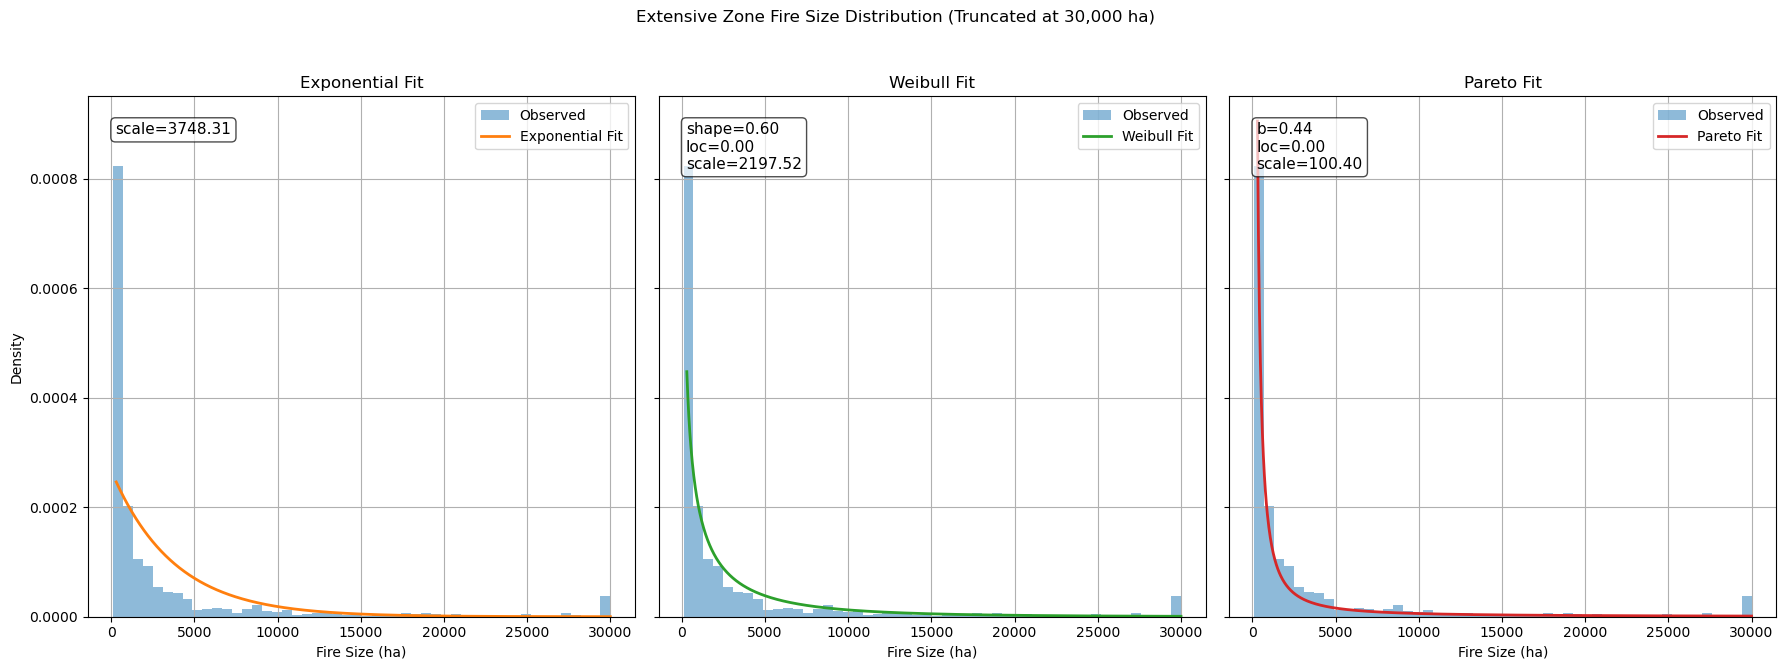

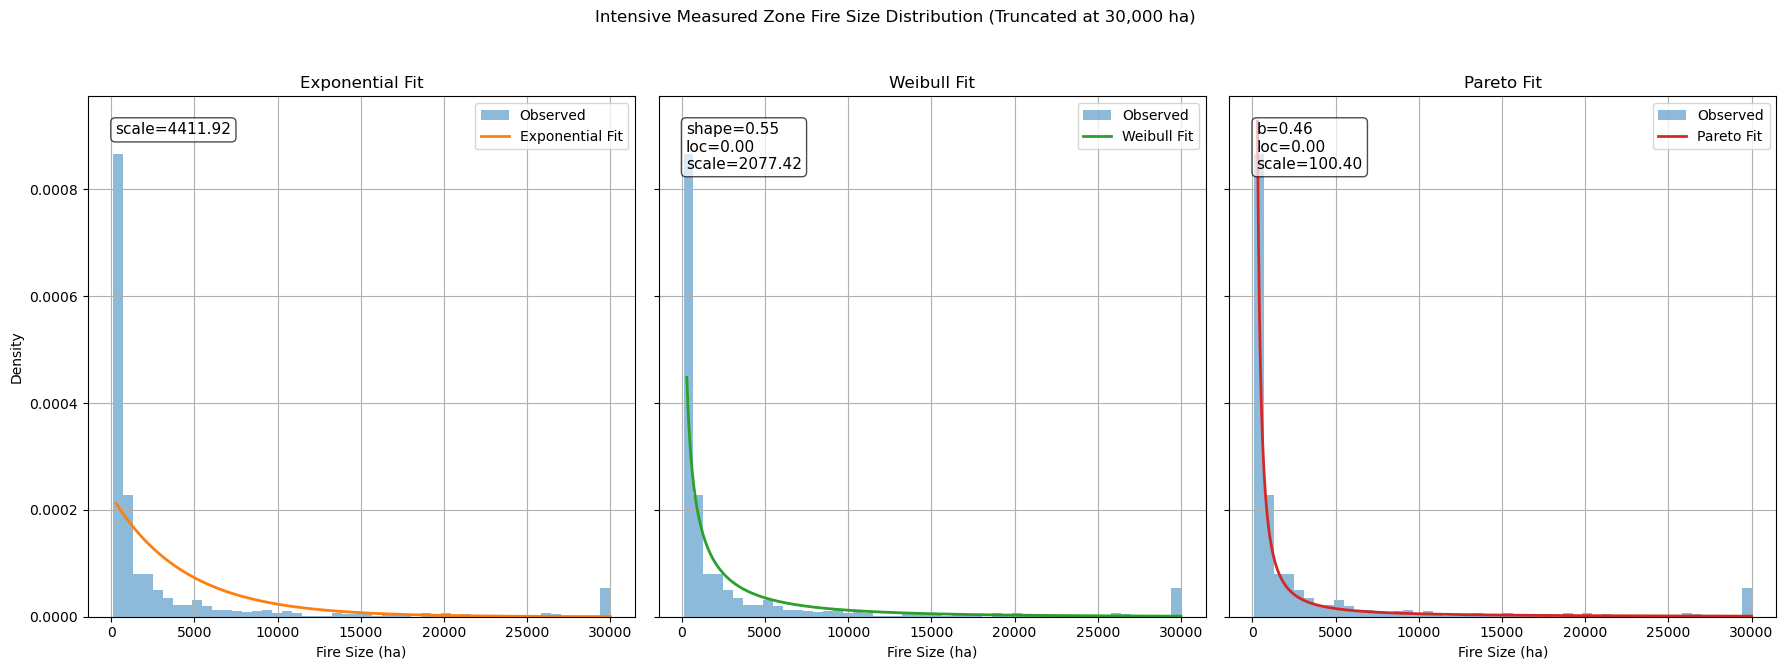

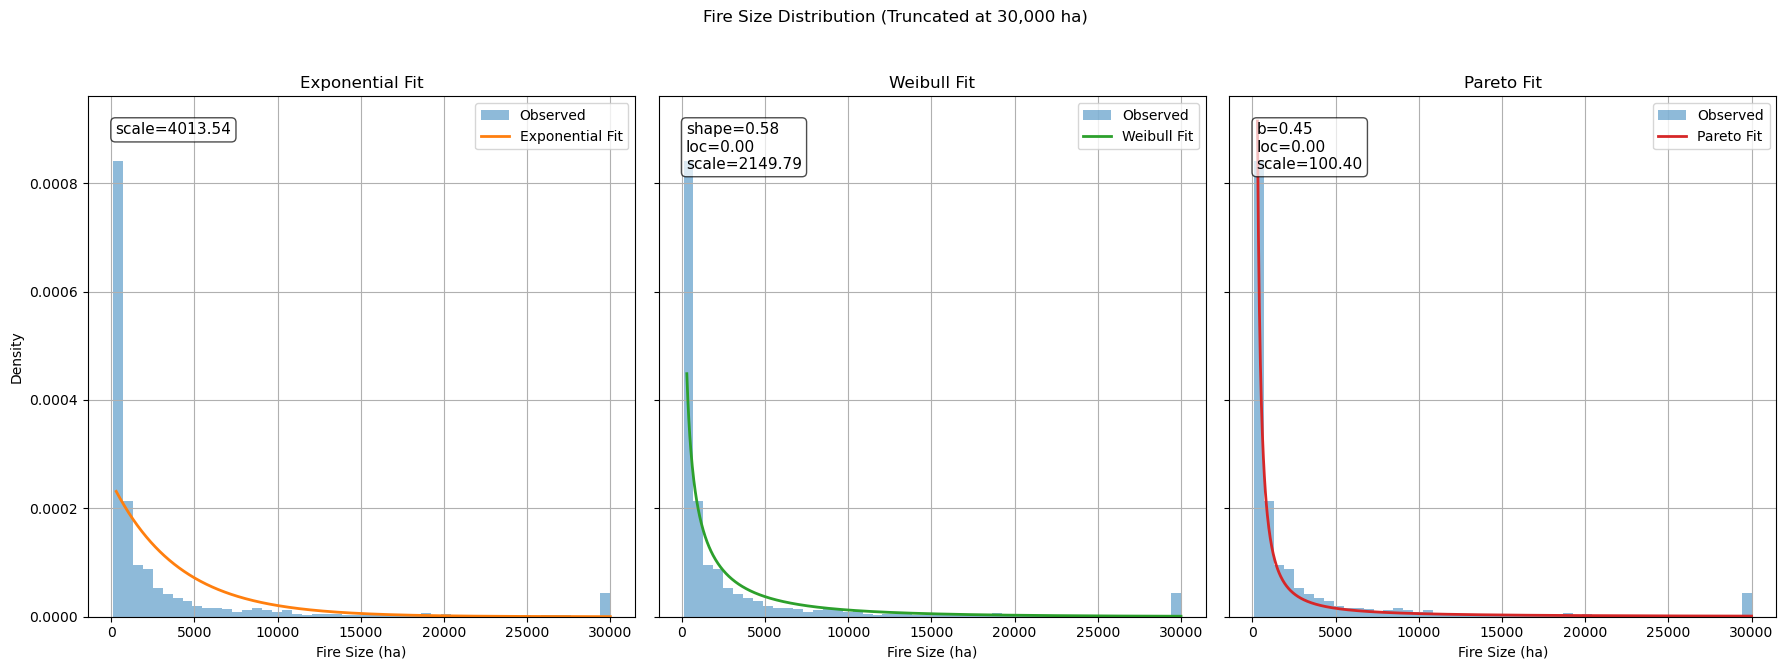

In [69]:
# get parameters for fire size distribution
fire_size_params = fit_fire_size_distribution(extensive['SIZE_HA'])

plot_fire_size_distribution(extensive['SIZE_HA'], 
                            fire_size_params, 
                            upper_limit=30000, 
                            title='Extensive Zone Fire Size Distribution (Truncated at 30,000 ha)')

fire_size_params = fit_fire_size_distribution(intensive['SIZE_HA'])

plot_fire_size_distribution(intensive['SIZE_HA'], 
                            fire_size_params, 
                            upper_limit=30000, 
                            title='Intensive Measured Zone Fire Size Distribution (Truncated at 30,000 ha)')

fire_size_params = fit_fire_size_distribution(all_fires['SIZE_HA'])

plot_fire_size_distribution(all_fires['SIZE_HA'], 
                            fire_size_params, 
                            upper_limit=30000, 
                            title='Fire Size Distribution (Truncated at 30,000 ha)')

In [64]:
pareto_b, pareto_loc, pareto_scale = fire_size_params['pareto']
value = 5000  # example fire size

cdf_val = stats.pareto.cdf(30000, pareto_b, loc=pareto_loc, scale=pareto_scale)
print(cdf_val)

0.9221523898249476


In [67]:
# percentage of all fires less than 30000 ha using actual data
percentage_less_than_30000 = (all_fires['SIZE_HA'] < 30000).mean() * 100
percentage_less_than_30000

np.float64(97.43178170144462)

# Modeling Fire Counts

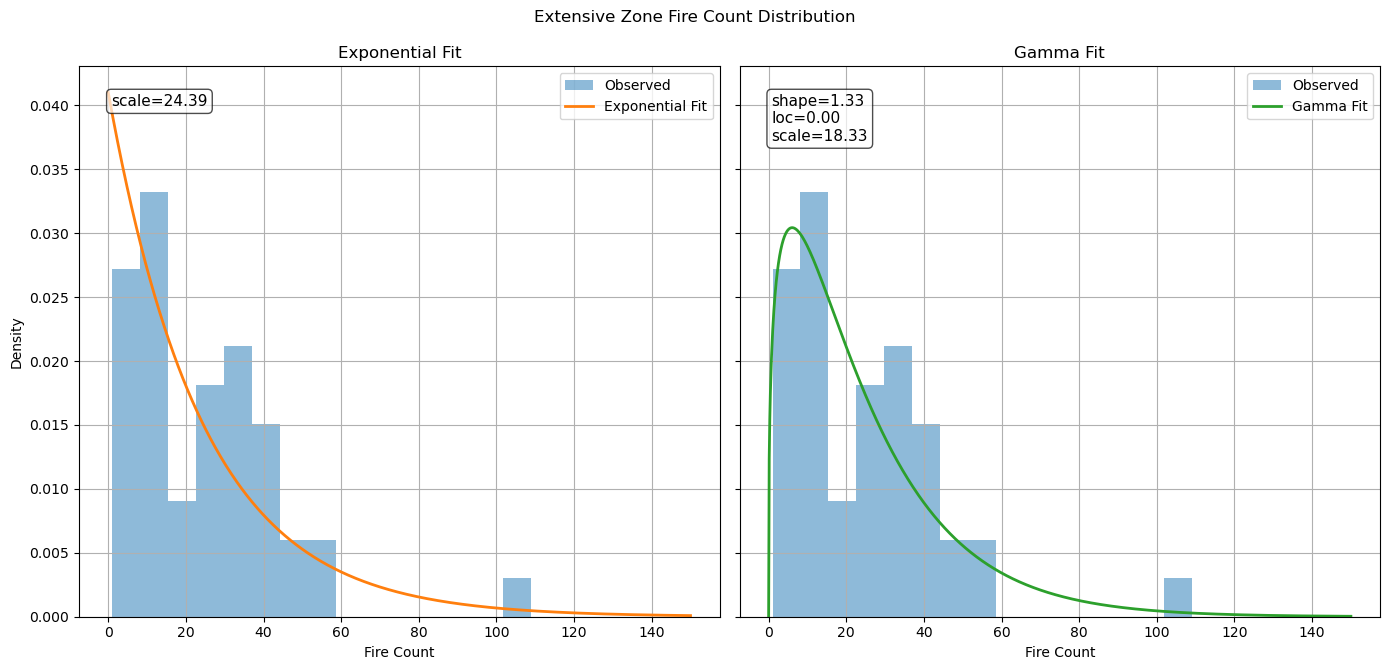

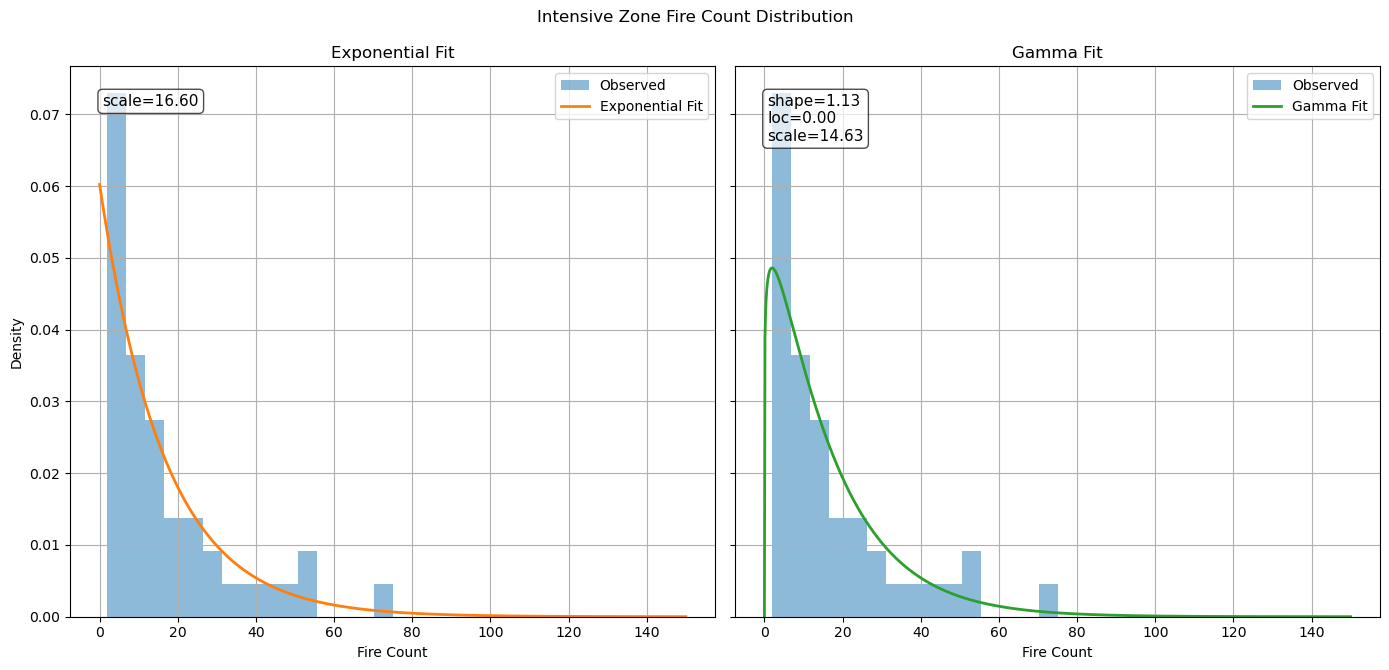

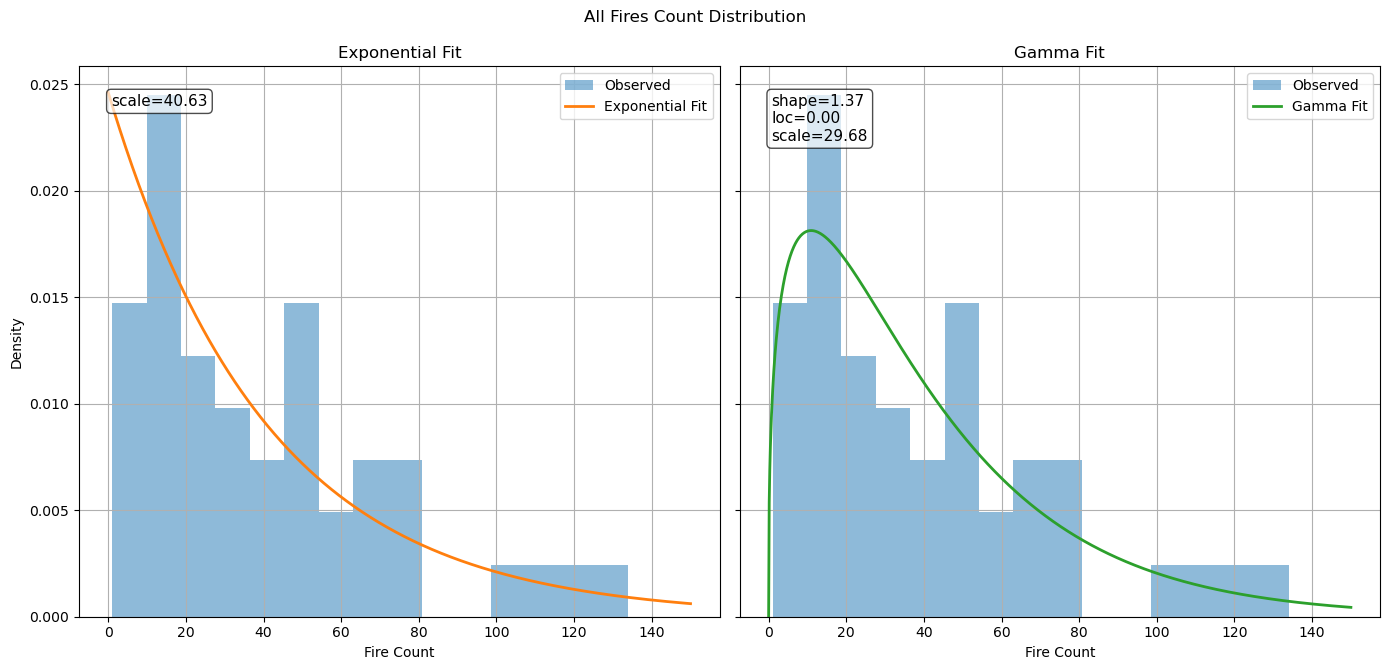

In [86]:
# group by year and get the count of fires
fire_counts_extensive = extensive.groupby('YEAR')['SIZE_HA'].count()
fire_counts_intensive = intensive.groupby('YEAR')['SIZE_HA'].count()
fire_counts_all = all_fires.groupby('YEAR')['SIZE_HA'].count()

# get parameters for Cox process
cox_params = fit_cox_process(fire_counts_extensive)

# plot fire count distribution
plot_fire_count_distribution(fire_counts_extensive, cox_params, title='Extensive Zone Fire Count Distribution')

# get parameters for Cox process for intensive zone
cox_params_intensive = fit_cox_process(fire_counts_intensive)

# plot fire count distribution for intensive zone
plot_fire_count_distribution(fire_counts_intensive, cox_params_intensive, title='Intensive Zone Fire Count Distribution')

# get parameters for Cox process for all fires
cox_params_all = fit_cox_process(fire_counts_all)

# plot fire count distribution for all fires
plot_fire_count_distribution(fire_counts_all, cox_params_all, title='All Fires Count Distribution')

# Simulation

In [130]:
# get parameters for fire size distribution
fire_size_params = fit_fire_size_distribution(extensive['SIZE_HA'])

# get the number of fires each year
fire_counts = extensive.groupby('YEAR').size()

# get parameters for the Cox process
cox_params = fit_cox_process(fire_counts)

# generate samples
simulated_number_fires = generate_samples(cox_params, size=10000)

# apply generate_fire_area to the simulated number of fires
gamma_cox_simulated_fires = [generate_fire_area(x, fire_size_params) for x in simulated_number_fires['gamma']]

# Convert list of dicts to DataFrame
gamma_cox_simulated_fires_df_extensive = pd.DataFrame(gamma_cox_simulated_fires)

# truncate all values to 1000000
gamma_cox_simulated_fires_df_extensive_truncated = gamma_cox_simulated_fires_df_extensive.clip(upper=1000000)

# Melt the DataFrame to long format
long_df = gamma_cox_simulated_fires_df_extensive_truncated.melt(var_name='distribution', value_name='total_area')


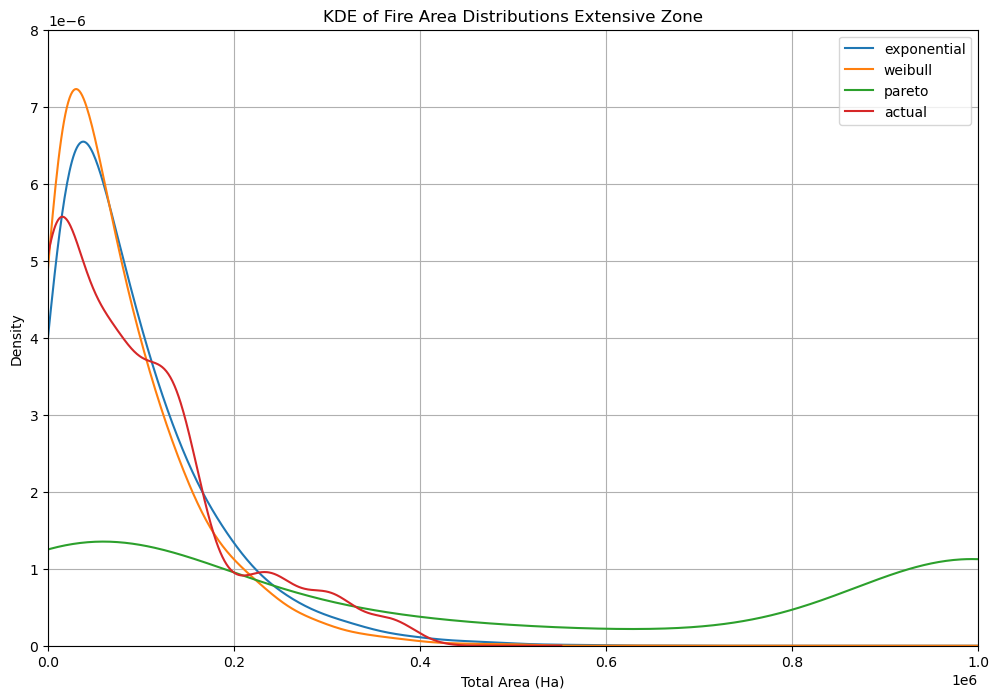

In [131]:
#group extensive by year and sum the total SIZE_HA

extensive_grouped = extensive.groupby('YEAR')['SIZE_HA'].sum().reset_index()

# add to long df but remove the year and the disteibution is called 'actual'
extensive_grouped.rename(columns={'SIZE_HA': 'total_area'}, inplace=True)
extensive_grouped['distribution'] = 'actual'
# drop the YEAR column
extensive_grouped.drop(columns='YEAR', inplace=True)

# concatenate the two DataFrames
combined_df = pd.concat([long_df, extensive_grouped], ignore_index=True)

# plot kde of the three distributions
plt.figure(figsize=(12, 8))
for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]
    subset['total_area'].plot.kde(label=distribution, bw_method=0.3)

plt.title('KDE of Fire Area Distributions Extensive Zone')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000008)
plt.grid()
plt.show()


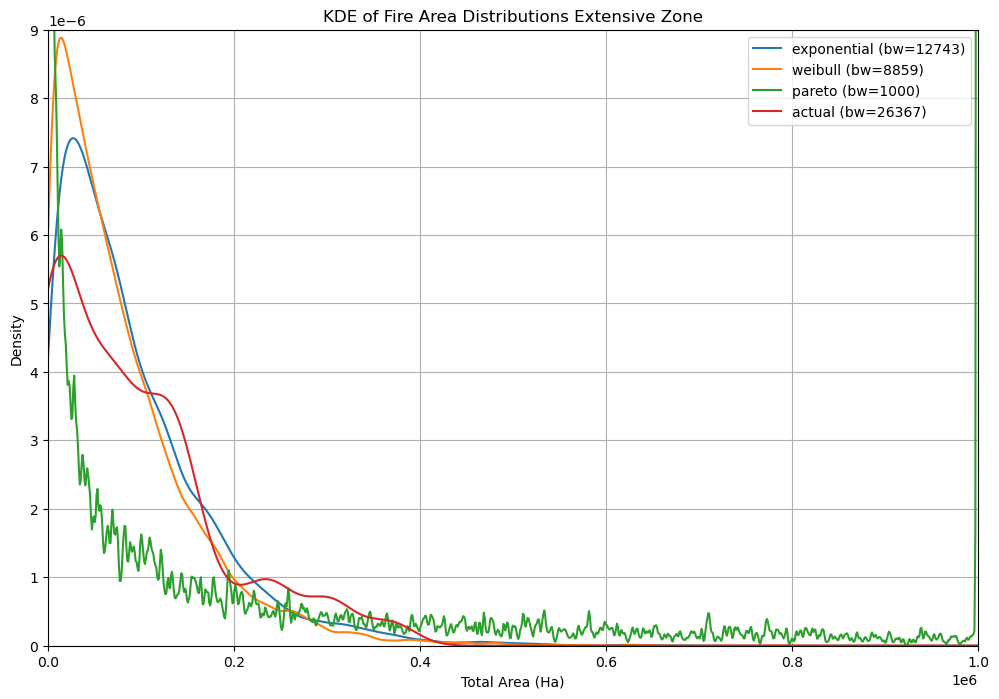

In [126]:
# ...existing code...

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import numpy as np

plt.figure(figsize=(12, 8))

for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]['total_area'].dropna()
    X = subset.values[:, None]

    # Define a range of bandwidths to try
    bandwidths = np.logspace(3, 6, 20)  # Adjust range as needed (e.g., 1e3 to 1e6)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=5)
    grid.fit(X)

    best_bandwidth = grid.best_params_['bandwidth']
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
    kde.fit(X)

    x_d = np.linspace(0, 1000000, 1000)
    log_dens = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(log_dens), label=f"{distribution} (bw={best_bandwidth:.0f})")

plt.title('KDE of Fire Area Distributions Extensive Zone')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()
# ...existing code...

# Intensive Zone

In [132]:
# get parameters for fire size distribution
fire_size_params = fit_fire_size_distribution(intensive['SIZE_HA'])

# get the number of fires each year
fire_counts = intensive.groupby('YEAR').size()

# get parameters for the Cox process
cox_params = fit_cox_process(fire_counts)

# generate samples
simulated_number_fires = generate_samples(cox_params, size=10000)

# apply generate_fire_area to the simulated number of fires
gamma_cox_simulated_fires_intensive = [generate_fire_area(x, fire_size_params) for x in simulated_number_fires['gamma']]

# Convert list of dicts to DataFrame
gamma_cox_simulated_fires_df_intensive = pd.DataFrame(gamma_cox_simulated_fires_intensive)

# truncate all values to 1000000
gamma_cox_simulated_fires_df_intensive_truncated = gamma_cox_simulated_fires_df_intensive.clip(upper=1000000)

# Melt the DataFrame to long format
long_df = gamma_cox_simulated_fires_df_intensive_truncated.melt(var_name='distribution', value_name='total_area')

# Melt the DataFrame to long format
long_df = gamma_cox_simulated_fires_df.melt(var_name='distribution', value_name='total_area')


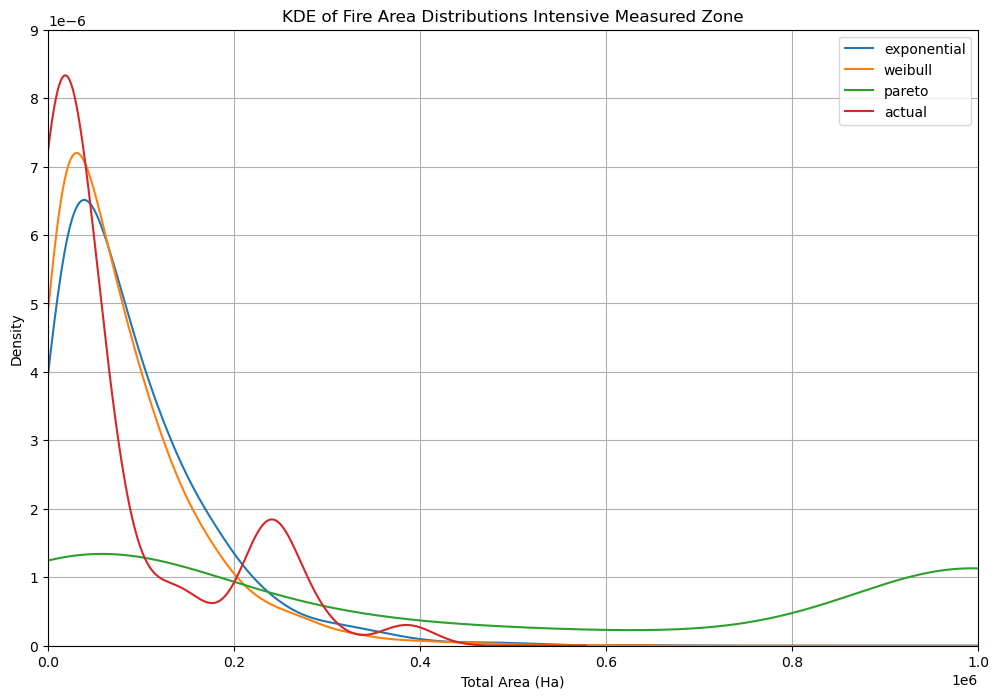

In [121]:
#group extensive by year and sum the total SIZE_HA

extensive_grouped = intensive.groupby('YEAR')['SIZE_HA'].sum().reset_index()

# add to long df but remove the year and the disteibution is called 'actual'
extensive_grouped.rename(columns={'SIZE_HA': 'total_area'}, inplace=True)
extensive_grouped['distribution'] = 'actual'
# drop the YEAR column
extensive_grouped.drop(columns='YEAR', inplace=True)

# concatenate the two DataFrames
combined_df = pd.concat([long_df, extensive_grouped], ignore_index=True)

# plot kde of the three distributions
plt.figure(figsize=(12, 8))
for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]
    subset['total_area'].plot.kde(label=distribution, bw_method=0.3)

plt.title('KDE of Fire Area Distributions Intensive Measured Zone')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()


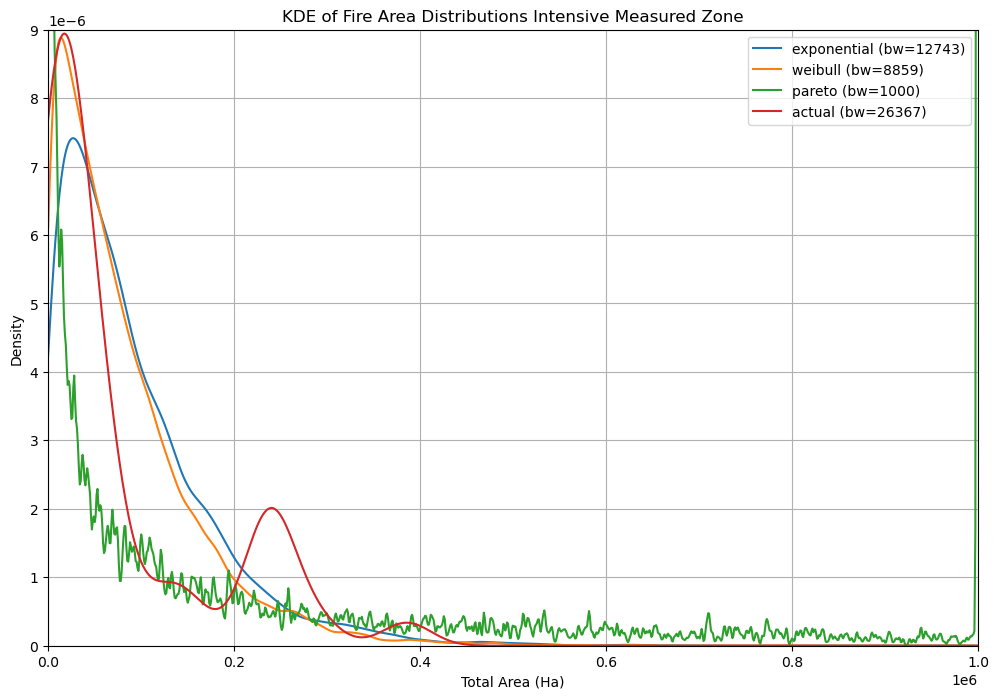

In [122]:
# ...existing code...

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import numpy as np

plt.figure(figsize=(12, 8))

for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]['total_area'].dropna()
    X = subset.values[:, None]

    # Define a range of bandwidths to try
    bandwidths = np.logspace(3, 6, 20)  # 1e3 to 1e6, adjust if needed
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=5)
    grid.fit(X)

    best_bandwidth = grid.best_params_['bandwidth']
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
    kde.fit(X)

    x_d = np.linspace(0, 1000000, 1000)
    log_dens = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(log_dens), label=f"{distribution} (bw={best_bandwidth:.0f})")

plt.title('KDE of Fire Area Distributions Intensive Measured Zone')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()
# ...existing code...

# All Zones

In [127]:
# get parameters for fire size distribution
fire_size_params = fit_fire_size_distribution(all_fires['SIZE_HA'])

# get the number of fires each year
fire_counts = all_fires.groupby('YEAR').size()

# get parameters for the Cox process
cox_params = fit_cox_process(fire_counts)

# generate samples
simulated_number_fires = generate_samples(cox_params, size=10000)

# apply generate_fire_area to the simulated number of fires
gamma_cox_simulated_fires_all = [generate_fire_area(x, fire_size_params) for x in simulated_number_fires['gamma']]

# Convert list of dicts to DataFrame
gamma_cox_simulated_fires_df_all = pd.DataFrame(gamma_cox_simulated_fires_all)

# truncate all values to 1000000
gamma_cox_simulated_fires_df_all_truncated = gamma_cox_simulated_fires_df_all.clip(upper=1000000)

# Melt the DataFrame to long format
long_df = gamma_cox_simulated_fires_df_all_truncated.melt(var_name='distribution', value_name='total_area')



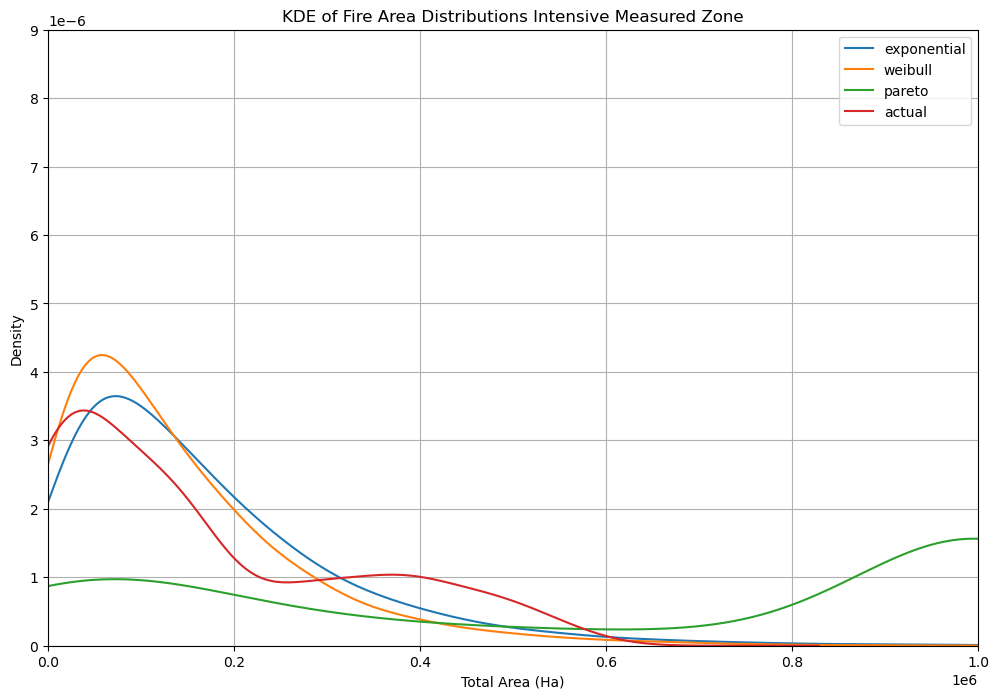

In [ ]:
#group extensive by year and sum the total SIZE_HA

extensive_grouped = all_fires.groupby('YEAR')['SIZE_HA'].sum().reset_index()

# add to long df but remove the year and the disteibution is called 'actual'
extensive_grouped.rename(columns={'SIZE_HA': 'total_area'}, inplace=True)
extensive_grouped['distribution'] = 'actual'
# drop the YEAR column
extensive_grouped.drop(columns='YEAR', inplace=True)

# concatenate the two DataFrames
combined_df = pd.concat([long_df, extensive_grouped], ignore_index=True)

# plot kde of the three distributions
plt.figure(figsize=(12, 8))
for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]
    subset['total_area'].plot.kde(label=distribution, bw_method=0.3)

plt.title('KDE of Fire Area Distributions All Zones')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()


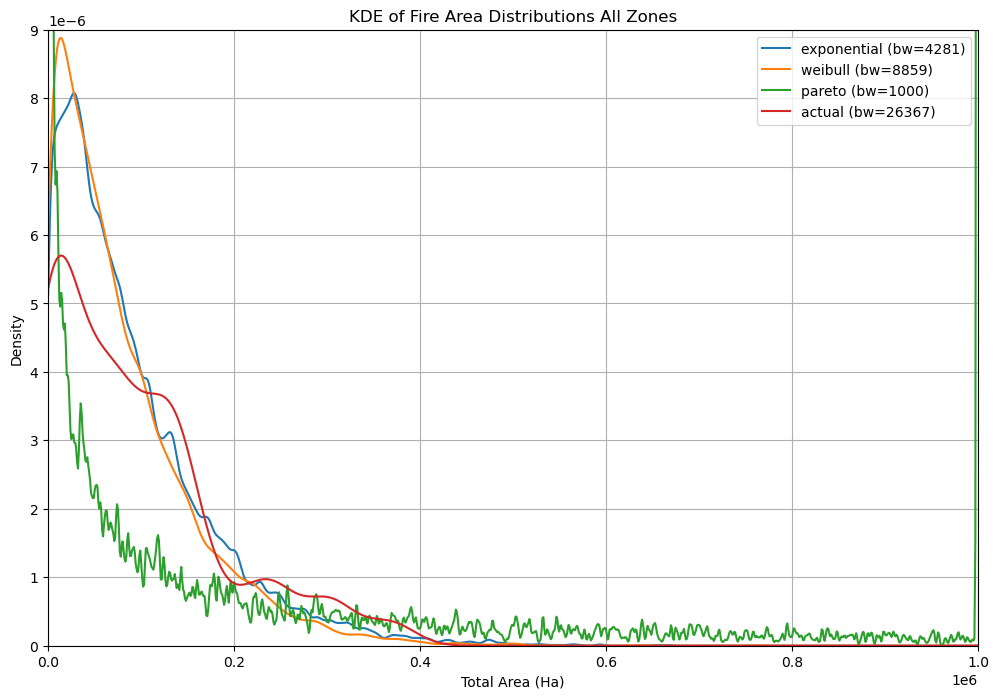

In [133]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import numpy as np

plt.figure(figsize=(12, 8))

for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]['total_area'].dropna()
    X = subset.values[:, None]

    # Define a range of bandwidths to try
    bandwidths = np.logspace(3, 6, 20)  # 1e3 to 1e6, adjust if needed
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=5)
    grid.fit(X)

    best_bandwidth = grid.best_params_['bandwidth']
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
    kde.fit(X)

    x_d = np.linspace(0, 1000000, 1000)
    log_dens = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(log_dens), label=f"{distribution} (bw={best_bandwidth:.0f})")

plt.title('KDE of Fire Area Distributions All Zones')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()

# Temporal Trend

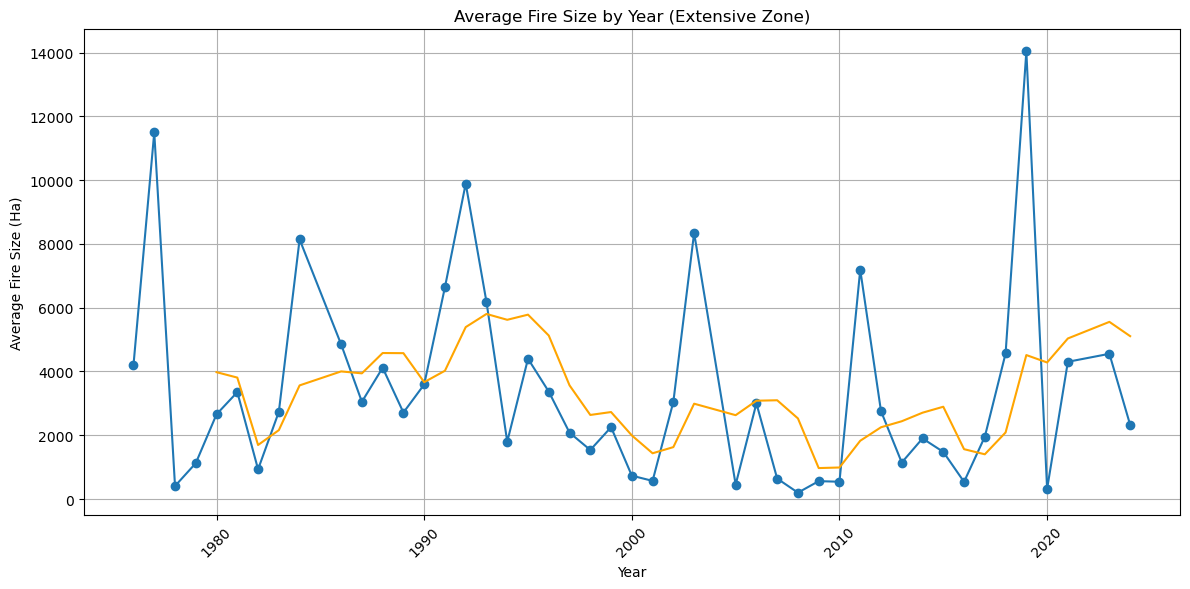

In [90]:
# average fire size by year
average_fire_size_extensive = extensive.groupby('YEAR')['SIZE_HA'].mean().reset_index()

# plot average fire size by year 
plt.figure(figsize=(12, 6))
plt.plot(average_fire_size_extensive['YEAR'], average_fire_size_extensive['SIZE_HA'], marker='o', linestyle='-')
# plot a moving average
average_fire_size_extensive['SIZE_HA_MA'] = average_fire_size_extensive['SIZE_HA'].rolling(window=5).mean()
plt.plot(average_fire_size_extensive['YEAR'], average_fire_size_extensive['SIZE_HA_MA'], color='orange', label='5-Year Moving Average')
plt.title('Average Fire Size by Year (Extensive Zone)')
plt.xlabel('Year')
plt.ylabel('Average Fire Size (Ha)')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


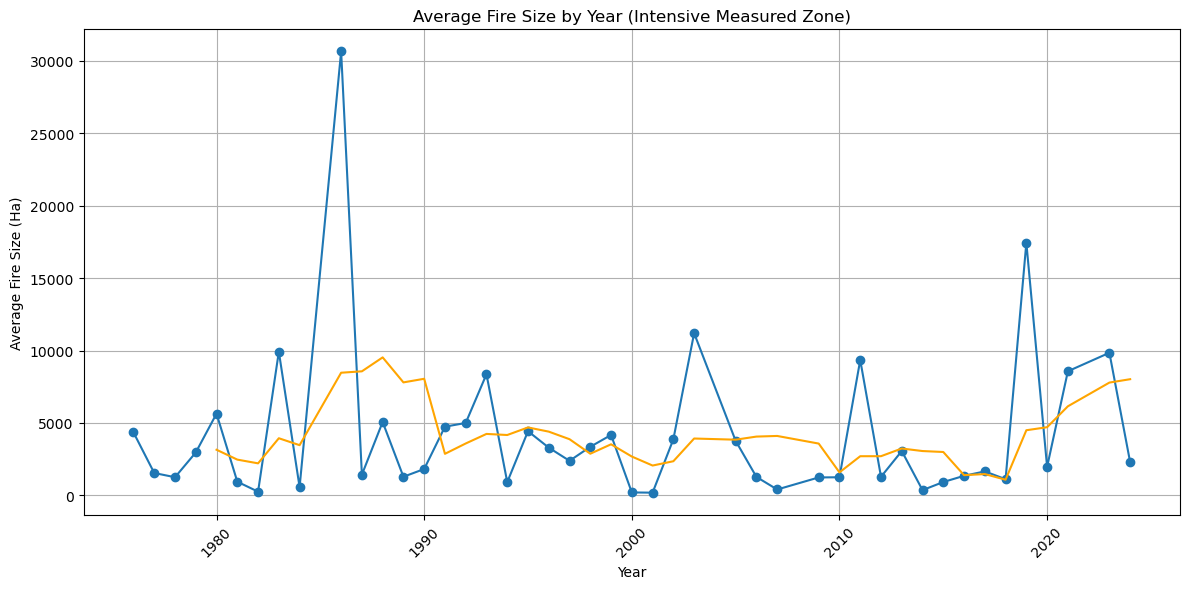

In [91]:
# Do the same for intensive zone
average_fire_size_intensive = intensive.groupby('YEAR')['SIZE_HA'].mean().reset_index()
# plot average fire size by year
plt.figure(figsize=(12, 6))
plt.plot(average_fire_size_intensive['YEAR'], average_fire_size_intensive['SIZE_HA'], marker='o', linestyle='-')
# plot a moving average
average_fire_size_intensive['SIZE_HA_MA'] = average_fire_size_intensive['SIZE_HA'].rolling(window=5).mean()
plt.plot(average_fire_size_intensive['YEAR'], average_fire_size_intensive['SIZE_HA_MA'], color='orange', label='5-Year Moving Average')
plt.title('Average Fire Size by Year (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Average Fire Size (Ha)')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

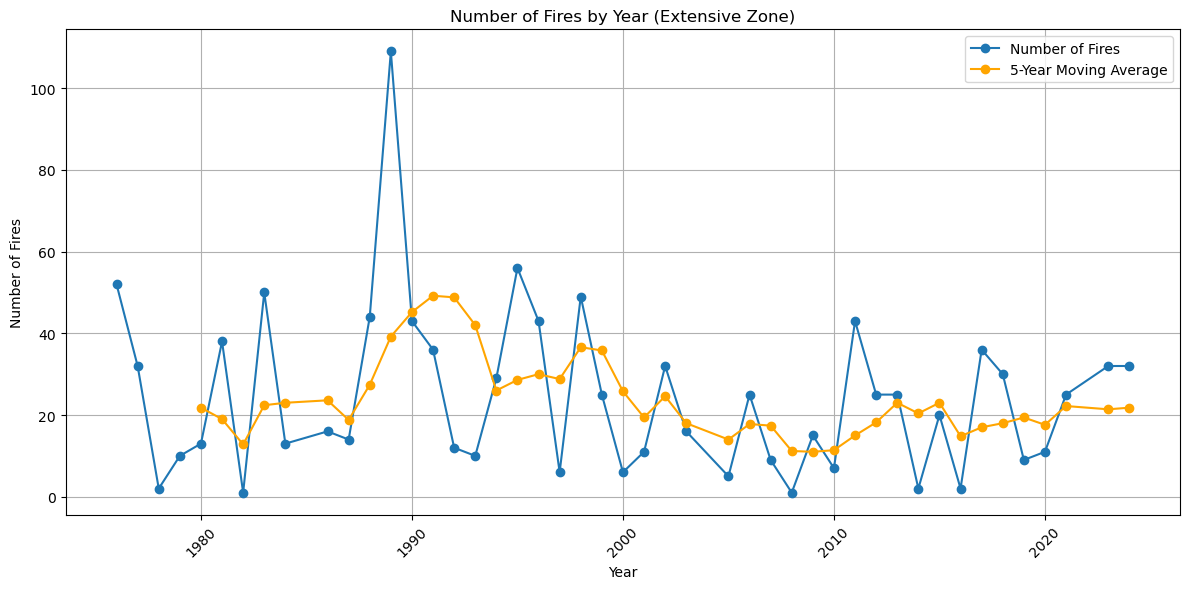

In [89]:
# number of fires by year and then do a moving average too
# number of fires by year
fire_counts_extensive = extensive.groupby('YEAR')['SIZE_HA'].count().reset_index()
# calculate moving average
fire_counts_extensive['moving_average'] = fire_counts_extensive['SIZE_HA'].rolling(window=5).mean()
# plot number of fires by year and moving average
plt.figure(figsize=(12, 6))
plt.plot(fire_counts_extensive['YEAR'], fire_counts_extensive['SIZE_HA'], marker='o', linestyle='-', label='Number of Fires')
plt.plot(fire_counts_extensive['YEAR'], fire_counts_extensive['moving_average'], marker='o', linestyle='-', color='orange', label='5-Year Moving Average')
plt.title('Number of Fires by Year (Extensive Zone)')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

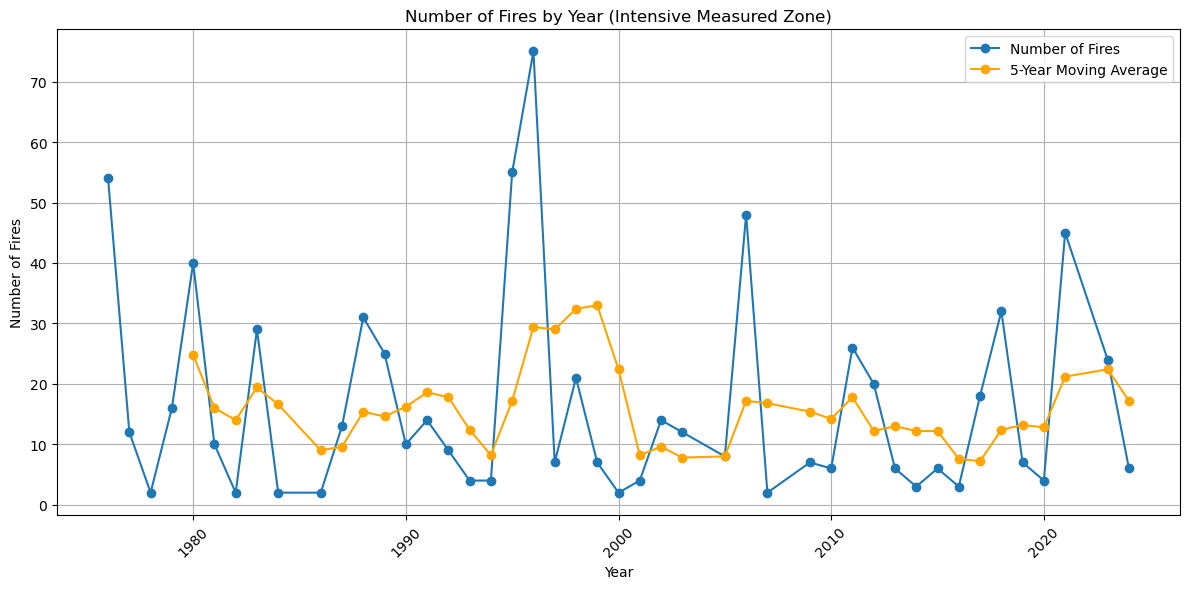

In [92]:
# dop the same for the intensive zone
# number of fires by year
fire_counts_intensive = intensive.groupby('YEAR')['SIZE_HA'].count().reset_index()
# calculate moving average
fire_counts_intensive['moving_average'] = fire_counts_intensive['SIZE_HA'].rolling(window=5).mean()
# plot number of fires by year and moving average
plt.figure(figsize=(12, 6))
plt.plot(fire_counts_intensive['YEAR'], fire_counts_intensive['SIZE_HA'], marker='o', linestyle='-', label='Number of Fires')
plt.plot(fire_counts_intensive['YEAR'], fire_counts_intensive['moving_average'], marker='o', linestyle='-', color='orange', label='5-Year Moving Average')
plt.title('Number of Fires by Year (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
